In [12]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

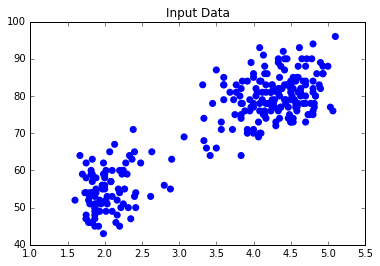

In [13]:
data = np.loadtxt('faithful.dat', skiprows=26, usecols=(1,2), dtype=np.float)
plt.scatter(data[:,0], data[:,1], s=[50]*len(data), linewidth=0, c='b')
_ = plt.title("Input Data")

In [14]:
import random
class KMeans():
    def __init__(self, max_iter=1000):
        self.max_iter = max_iter
        
    def fit(self, X, k):
        self.X = X
        self.N, self.p = X.shape
        self.k = k
        
        _ = set([])
        while len(_) < k:
            _.add(random.randint(0, self.N - 1))
        self.center = np.copy(X[tuple(_), :])
        assert self.center.shape == (self.k, self.p)
        
        self.status = np.zeros((self.N,))
        
        converge = False
        iter_count = 0
        while not converge and iter_count < self.max_iter:
            converge = True
            _status = np.apply_along_axis(self._get_center_idx, 1, X)
            
            if not np.array_equal(self.status, _status):
                converge = False
                self._update_center(_status)
                self.status = _status
            
            iter_count += 1
        self.iter_count = iter_count
        
    def _get_center_idx(self, x):
        return np.argmin(np.sum((self.center - x) ** 2, axis=1), axis=0)
        
    def _update_center(self, status):
        for i in range(self.k):
            _center = np.mean(self.X[status == i], axis=0)
            self.center[i] = _center
    
    def get_center(self):
        return self.center # shape: k*p
    
    def get_status(self):
        return self.status
    
    def get_cluster(self, k):
        return self.X[self.status == k]

In [15]:
from scipy.stats import multivariate_normal as mn

class GMM(object):
    def __init__(self, n_components, max_iter=500):
        self.n_components = n_components
        self.max_iter = 500
        pass

    def fit(self, X, persist=False, **kwargs):
        self.N, self.p = X.shape
        
        if len(kwargs) > 0:
            self.means = kwargs['means']
            self.covs = kwargs['cov']
            self.prior = kwargs['prior']
        else:
            # nc * p
            _ = np.arange(self.N)
            np.random.shuffle(_)
            _idx = _[:self.n_components]
            self.means = np.copy(X[_idx, :])
            #         print self.means

            # nc * p * p
            _X = X - np.mean(X, axis=0)
            _cov = np.dot(_X.T, _X) * np.identity(self.p) / float(self.N)
            self.covs = np.repeat(_cov[np.newaxis, :, :], self.n_components, axis=0)
            #         print self.covs

            # nc * 1
            self.prior = np.full((self.n_components, 1), 1.0 / self.n_components, dtype=float)
            #         print self.prior


        if persist:
            self.all_means = [self.means, ]
            self.all_covs = [self.means, ]
            self.all_prior = [self.prior, ]

        self.prob = np.zeros((self.N,))
        self.resp = np.zeros((self.n_components, self.N))
        for i in xrange(self.max_iter):
            resp, self.prob = self._e_step(X)

            if np.allclose(resp, self.resp):
                self.iter_times = i
                break

            _prior, _means, _covs = self._m_step(X, resp)

            if persist:
                self.all_means.append(_means)
                self.all_covs.append(_covs)

            self.resp = resp
            self.prior = _prior
            self.means = _means
            self.covs = _covs

        if not hasattr(self, "iter_times"):
            self.iter_times = self.max_iter

    def _e_step(self, X):
        """E-step of EM algorithm

        Return:
        ------
        gamma_s : responsibilities for each components and data point
        prob: probability density, shape (N,)
        """

        # shape: nc * N:  phis_ij - phi_j for component i
        phi_s = np.array([mn.pdf(X, self.means[i], self.covs[i])
                          for i in range(self.n_components)])

        # shape: nc * N / 1 * N = nc * N
        gamma_s = (self.prior * phi_s) / np.dot(self.prior.T, phi_s)
        #         print "resp: ", gamma_s

        assert np.allclose(np.sum(gamma_s, axis=0), np.ones(self.N))

        # TODO
        return gamma_s, np.dot(phi_s.T, self.prior)

    def _m_step(self, X, gamma_s):
        """M-Step of EM algorithm

        Update object's attributes: prior, means, and covs
        """

        _prior = (np.sum(gamma_s, axis=1) / self.N)[:, np.newaxis]

        _gamma_sum = np.sum(gamma_s, axis=1)  # nc*1

        # shape: nc * p
        _means = np.dot(gamma_s, X) / _gamma_sum[:, np.newaxis]  # nc * p / nc

        # shape: nc * p * p
        _covs = np.empty((self.n_components, self.p, self.p))
        for _i in range(self.n_components):
            _diff = X - _means[_i]
            _gamma = gamma_s[_i]
            assert _gamma.shape == (self.N,)
            _covs[_i, :, :] = np.dot(_gamma * _diff.T, _diff) * np.identity(self.p) / _gamma_sum[_i]

        return _prior, _means, _covs

    def _predict_prob(self, X):
        """Predict density given input X

        Paramter:
        ----
        X : input with shape N*p

        Returns:
        ---
        p : predicted density
        """
        if (self.iter_times < self.max_iter):
            _, prob = self._e_step(X)
            return prob
        else:
            print "Coefficients may not converge!"

    def predict(self, X):
        if (self.iter_times < self.max_iter):
            _, prob = self._e_step(X)
            return prob
        else:
            print "Coefficients may not converge!"

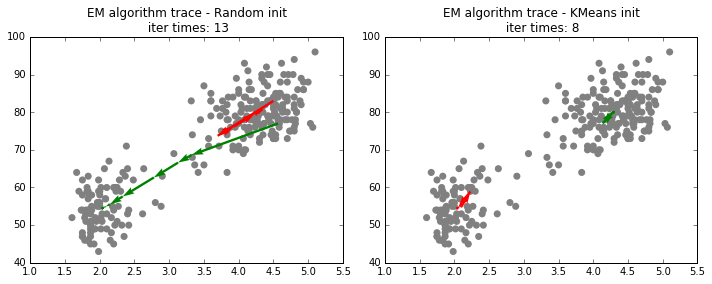

In [58]:
# plt.scatter(ttt[::2, 0], ttt[::2, 1], c='r')
# plt.scatter(ttt[1::2, 0], ttt[1::2, 1], c='g')

plt.figure(figsize=(10,4))

gmm = GMM(2)
gmm.fit(data,persist=True)
# print "iter times: %d" % gmm.iter_times
ttt = np.row_stack(tuple(gmm.all_means))
plt.subplot(1,2,1)
plt.scatter(data[:,0], data[:,1], s=[50]*len(data), linewidth=0, c='gray')
x, y = ttt[::2, 0], ttt[::2, 1]
plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1, color='g')
x, y = ttt[1::2, 0], ttt[1::2, 1]
plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1, color='r')
plt.title("EM algorithm trace - Random init\n iter times: %d" % gmm.iter_times)

plt.subplot(1,2,2)
gmm = GMM(2)
gmm.fit(data,persist=True, **init_param)
# print "iter times: %d" % gmm.iter_times
ttt = np.row_stack(tuple(gmm.all_means))
plt.subplot(1,2,2)
plt.scatter(data[:,0], data[:,1], s=[50]*len(data), linewidth=0, c='gray')
x, y = ttt[::2, 0], ttt[::2, 1]
plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1, color='g')
x, y = ttt[1::2, 0], ttt[1::2, 1]
plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1, color='r')
plt.title("EM algorithm trace - KMeans init\n iter times: %d" % gmm.iter_times)
plt.tight_layout()

In [59]:
def get_init_componens():
    kmeans = KMeans()
    kmeans.fit(data, 2)
    _cluster0 = data[kmeans.status == 0]
    _cluster1 = data[kmeans.status == 1]
    _cov = np.empty((2, 2, 2))
    _cov[0, :, :] = np.dot(_cluster0.T, _cluster0) / float(len(_cluster0))
    _cov[1, :, :] = np.dot(_cluster1.T, _cluster1) / float(len(_cluster1))

    _prior = [float(len(_cluster0)) / len(data), float(len(_cluster1)) / len(data)]

    init_param = {}
    init_param['means'] = kmeans.center
    init_param['cov'] = _cov
    init_param['prior'] = np.array(_prior)[:, np.newaxis]
    return init_param

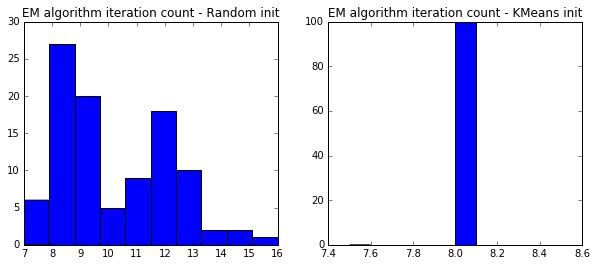

In [64]:
N = 100
iter_times1 = []
iter_times2 = []
for i in range(N):
    mdl1 = GMM(2)
    mdl2 = GMM(2)
    
    mdl1.fit(data)
    mdl2.fit(data, **get_init_componens())
    
    iter_times1.append(mdl1.iter_times)
    iter_times2.append(mdl2.iter_times)
    
plt.figure(figsize=(10,4)) 
plt.subplot(1,2,1)
_ = plt.hist(iter_times1) 
plt.title("EM algorithm iteration count - Random init")
plt.subplot(1,2,2)
_ = plt.hist(iter_times2)
plt.title("EM algorithm iteration count - KMeans init")

In [320]:
%whos

Variable       Type                       Data/Info
---------------------------------------------------
GMM            type                       <class '__main__.GMM'>
N              int                        50
X              ndarray                    3x2: 6 elems, type `int64`, 48 bytes
a              ndarray                    3x1: 3 elems, type `float64`, 24 bytes
b              ndarray                    3x2: 6 elems, type `float64`, 48 bytes
cov            ndarray                    2x2: 4 elems, type `float64`, 32 bytes
covs           ndarray                    2x2x2: 8 elems, type `float64`, 64 bytes
data           ndarray                    272x2: 544 elems, type `float64`, 4352 bytes
gmm            GMM                        <__main__.GMM object at 0x7fc68b4ef5d0>
i              int                        49
iter_times     list                       n=50
mdl            GMM                        <__main__.GMM object at 0x7fc68bc52b50>
mean           ndarray                